# Homework 9
- Min Je (John) Kim
- 11/9/2025

In [27]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

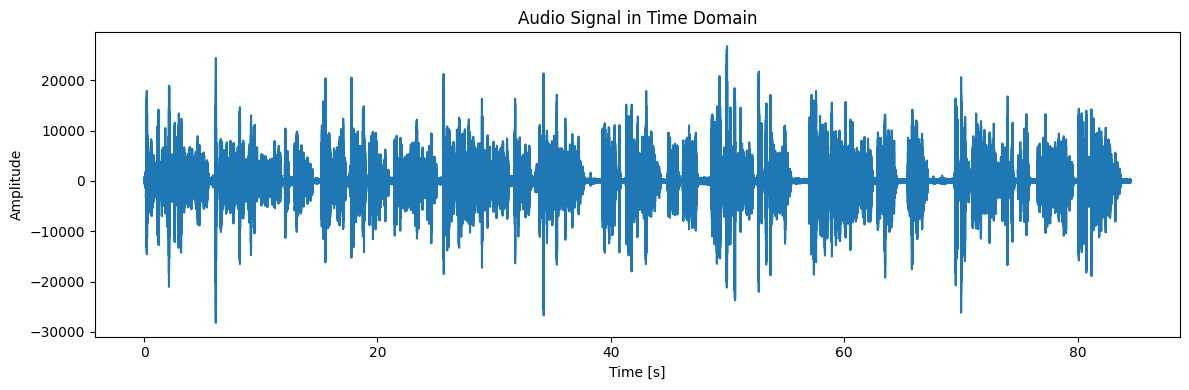

' The file seems to have very segmented audio spikes where I was talking and and where I was taking a breath/thinking of things to say next. The signal is definitely not periodic.'

In [28]:
""" Problem 1 Part A"""

audioFile = wav.read("FourierTransformRecording.wav")

sampleRate = audioFile[0]
audioMono = audioFile[1][:, 0].astype(float)
time = np.arange(len(audioMono)) / sampleRate

plt.figure(figsize=(12, 4))
plt.plot(time, audioMono)
plt.title("Audio Signal in Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

""" The file seems to have very segmented audio spikes where I was talking and and where I was taking a breath/thinking of things to say next. The signal is definitely not periodic."""

In [29]:
""" Problem 1 Part B """

def dft(signal, sampleRate):
    N = len(signal)                                     # Number of samples
    n = np.arange(N)                                    # Sample indices    
    k = n.reshape((N, 1))                               # Frequency indices
    M = np.exp(-2j * np.pi * k * n / N)                 # DFT matrix
    return(np.dot(M, signal), n * sampleRate / N)       # DFT and frequency axis
# ^ Abandoned this method due to memory issues with large N (Required ~N^2 memory or around 959 TiB for this signal)

def dft_naive(signal, sampleRate):
    N = len(signal)                                     # Number of samples
    n = np.arange(N)                                    # Sample indices
    X = np.zeros(N, dtype=complex)                      # DFT output

    for k in range(N):                                  # For each frequency bin
        exponent = -2j * np.pi * k * n / N                  # Exponent term
        X[k] = np.sum(signal * np.exp(exponent))            # DFT sum
    return (X, n * sampleRate / N)                      # DFT and frequency axis    
# ^ Abandoned this method due to time issues with large N (Gave up running after 30 minutes)

def dft_subset(signal, sampleRate, max_freq = 4000, freq_step = 5):
    N = len(signal)                                     # Number of samples
    n = np.arange(N)                                    # Sample indices

    k_max = int(max_freq * N / sampleRate)              # Max frequency index
    k_step = max(1, int(freq_step * N / sampleRate))    # Frequency index step
    k_vals = np.arange(0, k_max + 1, k_step)            # Frequency indices

    X = np.zeros(len(k_vals), dtype=complex)            # DFT output

    for i, k in enumerate(k_vals):                      # For each frequency bin
        exponent = -2j * np.pi * k * n / N                  # Exponent term
        X[i] = np.sum(signal * np.exp(exponent))            # DFT sum

    freqs = k_vals * sampleRate / N                     # Frequency axis
    return X, freqs
# Using limited number of frequencies to reduce computation time and memory usage


dftResult, freqs = dft_subset(audioMono, sampleRate, max_freq = 4000, freq_step = 5)

""" I tried many different methods to compute the DFT including vectorized matrix multiplication and naive summation, but both were too slow or required too much memory for the full signal. The final method computes the DFT only for frequencies up to 12 kHz in steps of 50 Hz, which is a reasonable compromise between resolution and computation time."""

' I tried many different methods to compute the DFT including vectorized matrix multiplication and naive summation, but both were too slow or required too much memory for the full signal. The final method computes the DFT only for frequencies up to 12 kHz in steps of 50 Hz, which is a reasonable compromise between resolution and computation time.'

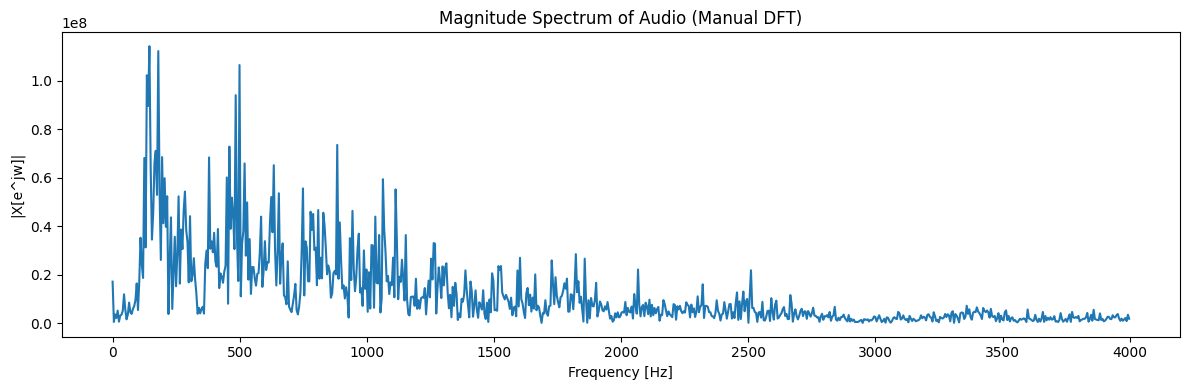

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(freqs, np.abs(dftResult))
plt.title("Magnitude Spectrum of Audio (Manual DFT)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|X[e^jw]|")
plt.tight_layout()
plt.show()


In [31]:
""" Problem 1 Part C """

from scipy.signal import find_peaks

mag = np.abs(dftResult)
peaks, _ = find_peaks(mag, distance= 5)
sorted_peaks = peaks[np.argsort(mag[peaks])[::-1]]
top_peaks = sorted_peaks[:3]

print("Top 3 frequency components (Hz):")
for peak in top_peaks:
    print(f"{freqs[peak]:.2f} Hz with magnitude {mag[peak]:.2f}")

Top 3 frequency components (Hz):
144.75 Hz with magnitude 114153773.84
179.69 Hz with magnitude 112113846.13
499.15 Hz with magnitude 106368854.66


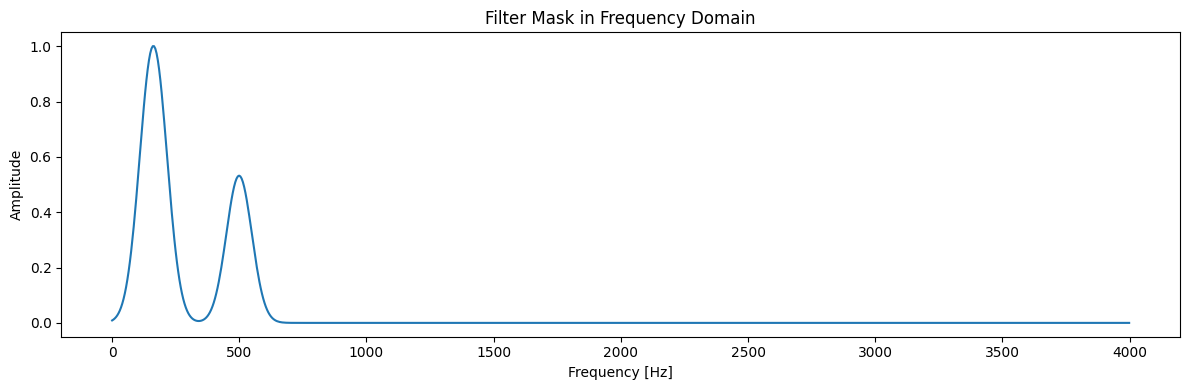

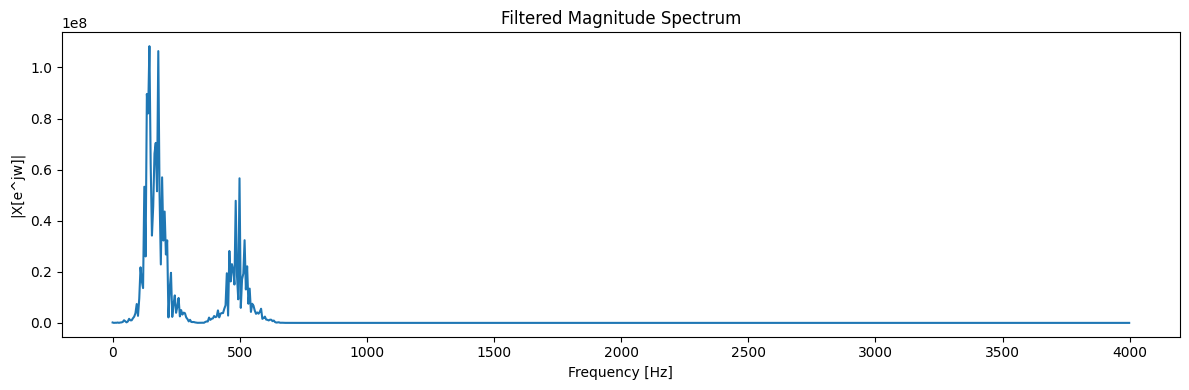

In [32]:
def Filter(freqs, peaks, bandwidth=50):
    mask = np.zeros_like(freqs, dtype=float)                    # Initialize mask variable               
    for p in peaks:                                             # for each peak
        mask += np.exp(-0.5 * ((freqs - p) / bandwidth)**2)         # Gaussian around each peak
    mask /= np.max(mask)                                        # Normalize to max of 1  
    return mask
# Never thought Gaussian Analysis Spark 010 Class would actually help me here XD

filterMask = Filter(freqs, freqs[top_peaks], bandwidth=50)
plt.figure(figsize=(12, 4))
plt.plot(freqs, filterMask)
plt.title("Filter Mask in Frequency Domain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

filteredDft = dftResult * filterMask
plt.figure(figsize=(12, 4))
plt.plot(freqs, np.abs(filteredDft))
plt.title("Filtered Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|X[e^jw]|")
plt.tight_layout()
plt.show()

In [33]:
def idft(dftResult):
    N = len(dftResult)                                  # Number of samples
    k = np.arange(N)                                    # Frequency indices
    n = k.reshape((N, 1))                               # Sample indices
    M_inv = np.exp(2j * np.pi * k * n / N)              # Inverse DFT matrix
    return (np.dot(M_inv, dftResult) / N).real          # IDFT and take real part
# Did not work as number of frequencies is less than original signal length

def idft_subset(dftResult, original_length):
    N = original_length                                                 # Original number of samples
    k_vals = np.arange(len(dftResult))                                  # Frequency indices
    n = np.arange(N).reshape((N, 1))                                    # Sample indices

    x_reconstructed = np.zeros(N, dtype=complex)                        # IDFT output

    for n_idx in range(N):                                              # For each time sample
        exponent = 2j * np.pi * freqs * n_idx / sampleRate                  # Exponent term
        x_reconstructed[n_idx] = np.sum(dftResult * np.exp(exponent))       # IDFT sum

    return (x_reconstructed / N).real                                   # IDFT and take real part
# ^ Did not run in a normal time frame (took 15+ minutes - Did not finish running)

N = len(audioMono)
t = np.arange(N) / sampleRate

def idft_subset_iter(X, freqs, sampleRate, N):
    t = np.arange(N) / sampleRate
    x = np.zeros(N, dtype=complex)
    for i in range(len(freqs)):
        x += X[i] * np.exp(2j * np.pi * freqs[i] * t)
    # normalize by number of frequency bins
    return (x.real / len(freqs))


idftResult = idft_subset_iter(dftResult, freqs, sampleRate, len(audioMono))
idftFilteredResult = idft_subset_iter(filteredDft, freqs, sampleRate, len(audioMono))

# scale for plotting / saving
idftResult /= np.max(np.abs(idftResult))
idftFilteredResult /= np.max(np.abs(idftFilteredResult))


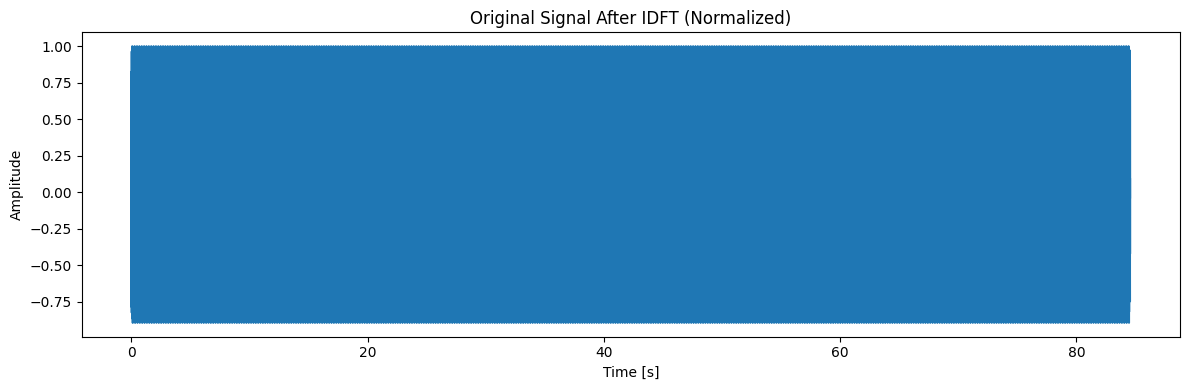

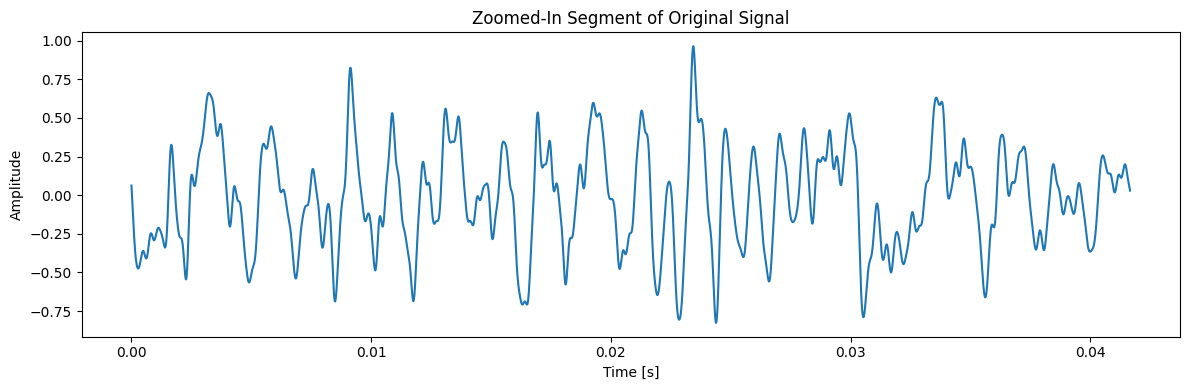

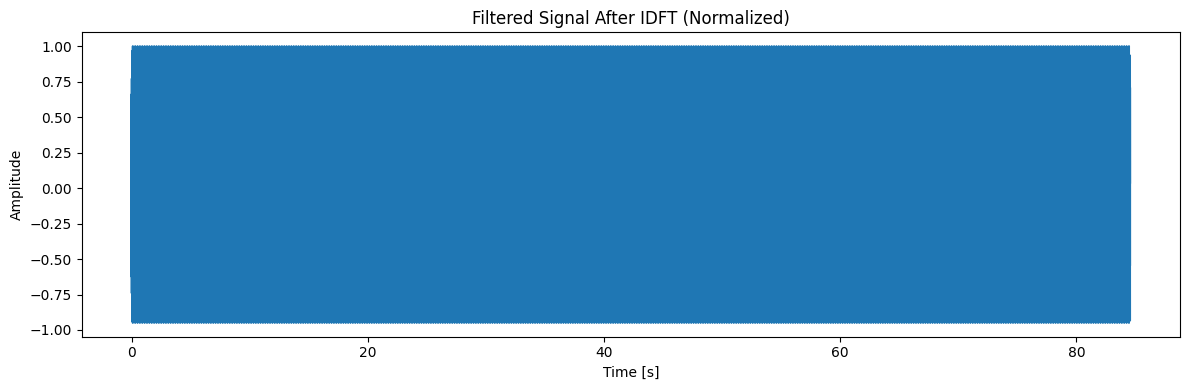

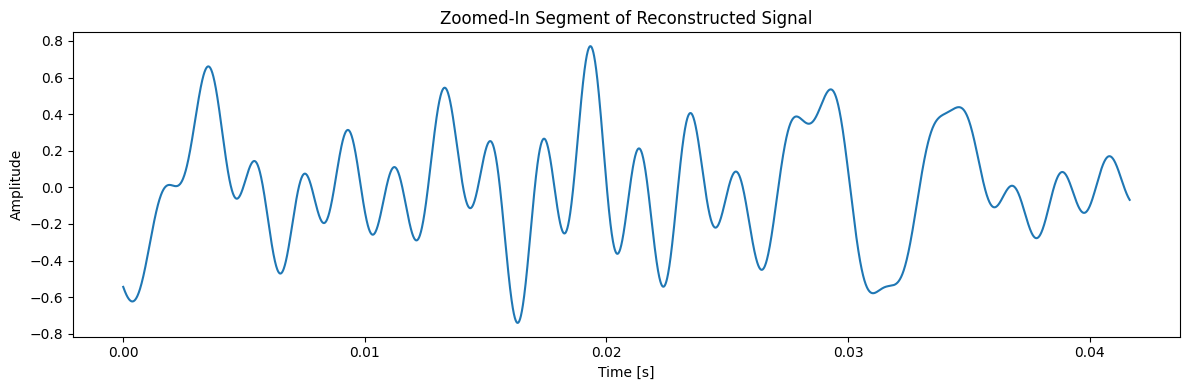

In [34]:
plt.figure(figsize=(12,4))
plt.plot(time, idftResult)
plt.title("Original Signal After IDFT (Normalized)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(time[:4000], idftResult[:4000])   # first 2000 samples ≈ 0.02 s
plt.title("Zoomed-In Segment of Original Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(time, idftFilteredResult)
plt.title("Filtered Signal After IDFT (Normalized)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(time[:4000], idftFilteredResult[:4000])   # first 2000 samples ≈ 0.02 s
plt.title("Zoomed-In Segment of Reconstructed Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [35]:
wav.write("ReconstructedPasscode.wav", sampleRate, np.array(idftFilteredResult, dtype=np.float32))

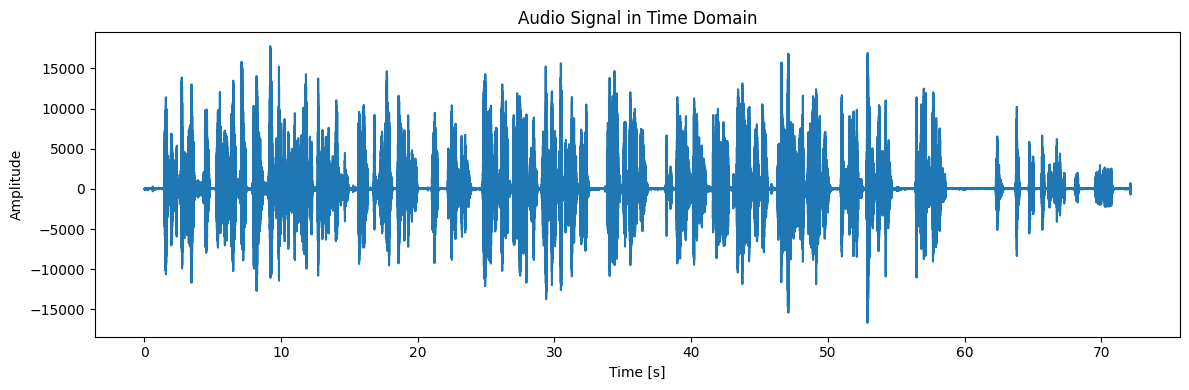

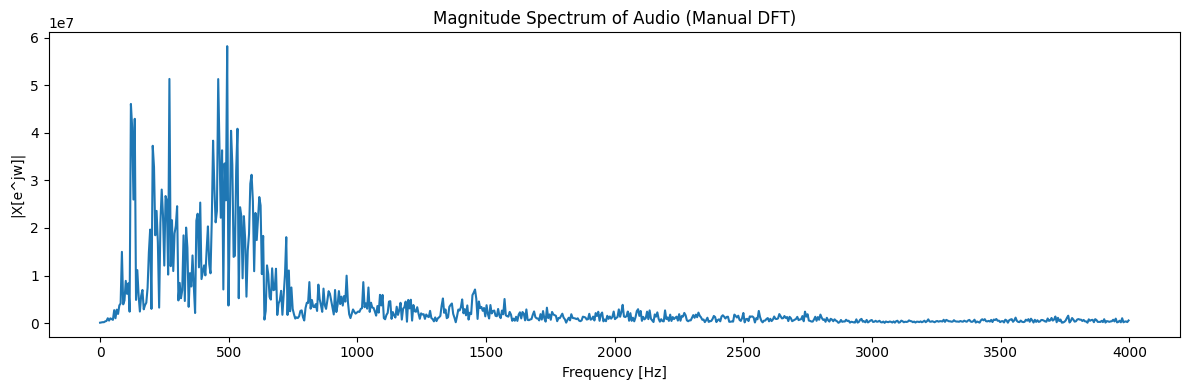

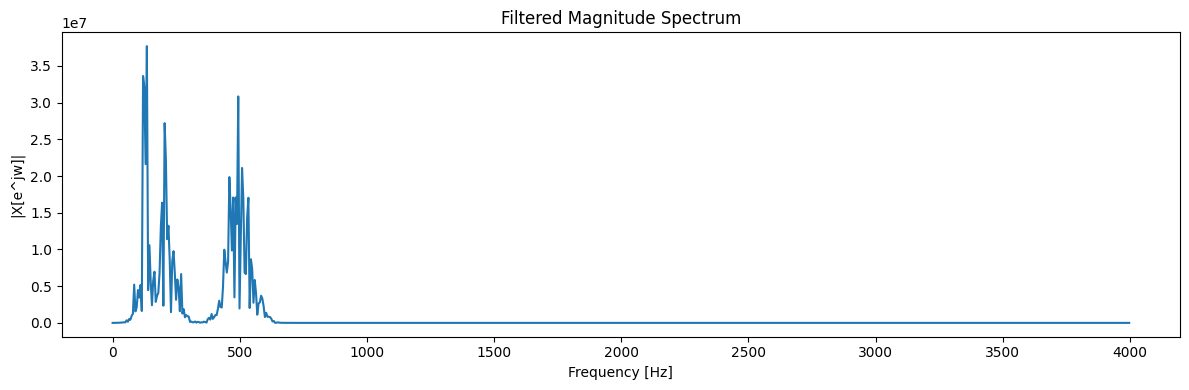

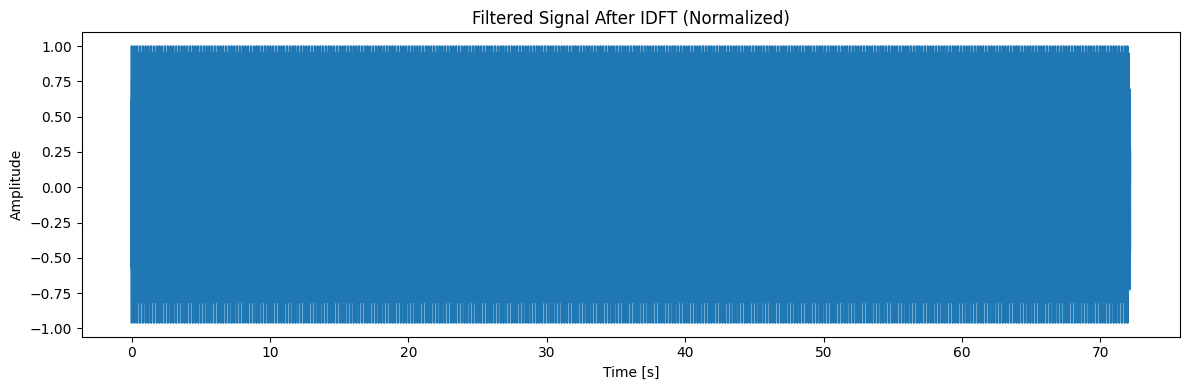

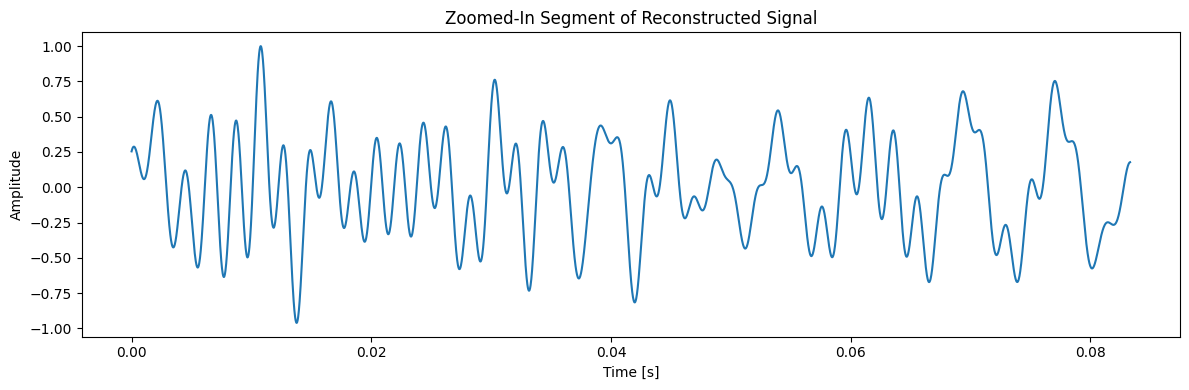

In [36]:
audioFile2 = wav.read("Convolutions!!!.wav")
sample2 = audioFile2[0]
audio2 = audioFile2[1].astype(float)
time2 = np.arange(len(audio2)) / sample2
plt.figure(figsize=(12, 4))
plt.plot(time2, audio2)
plt.title("Audio Signal in Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

dftResult2, freqs2 = dft_subset(audio2, sample2, max_freq = 4000, freq_step = 5)
plt.figure(figsize=(12, 4))
plt.plot(freqs2, np.abs(dftResult2))
plt.title("Magnitude Spectrum of Audio (Manual DFT)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|X[e^jw]|")
plt.tight_layout()
plt.show()

filteredDft2 = dftResult2 * filterMask
plt.figure(figsize=(12, 4))
plt.plot(freqs2, np.abs(filteredDft2))
plt.title("Filtered Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|X[e^jw]|")
plt.tight_layout()
plt.show()

idftResult2 = idft_subset_iter(dftResult2, freqs2, sample2, len(audio2))
idftFilteredResult2 = idft_subset_iter(filteredDft2, freqs2, sample2, len(audio2))

# scale for plotting / saving
idftResult2 /= np.max(np.abs(idftResult2))
idftFilteredResult2 /= np.max(np.abs(idftFilteredResult2))
plt.figure(figsize=(12,4))
plt.plot(time2, idftFilteredResult2)
plt.title("Filtered Signal After IDFT (Normalized)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,4))
plt.plot(time2[:4000], idftFilteredResult2[:4000])   # first 2000 samples ≈ 0.02 s
plt.title("Zoomed-In Segment of Reconstructed Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()
wav.write("ConvolutionsFiltered.wav", sample2, np.array(idftFilteredResult2, dtype=np.float32))



In [37]:
mag2 = np.abs(dftResult2)
peaks2, _ = find_peaks(mag2, distance= 2)
sorted_peaks2 = peaks2[np.argsort(mag2[peaks2])[::-1]]
top_peaks2 = sorted_peaks2[:3]

print("Top 3 frequency components (Hz):")
for peak2 in top_peaks2:
    print(f"{freqs2[peak2]:.2f} Hz with magnitude {mag2[peak2]:.2f}")

Top 3 frequency components (Hz):
493.98 Hz with magnitude 58248071.60
269.44 Hz with magnitude 51354856.81
459.05 Hz with magnitude 51325757.11
